# The model

Context and FLAME GPU resolution process

# Install and Import FLAME GPU

In [242]:
import pyflamegpu
import pyflamegpu.codegen
import sys, random, math
import matplotlib.pyplot as plt
#%env CUDA_PATH=/usr/local/cuda

# Some constants

Only available in host code!

In [243]:
# Environment size
GRID_WIDTH = 256
GRID_HEIGHT = GRID_WIDTH

# Agent state values 
AGENT_STATUS_UNOCCUPIED = 0
AGENT_STATUS_OCCUPIED = 1
AGENT_STATUS_MOVEMENT_REQUESTED = 2
AGENT_STATUS_MOVEMENT_UNRESOLVED = 3

# Initialisation parameters
ENV_SUGAR_MAX_CAPACITY = 4
ENV_SUGAR_GROWBACK_RATE = 1
MIN_HOTSPOT_DISTANCE = 20
MIN_INIT_AGENT_SUGAR_WEALTH = 5
MAX_INIT_AGENT_SUGAR_WEALTH = 25
MIN_INIT_METABOLISM = 1
MAX_INIT_METABOLISM = 4
PROBABILITY_OF_OCCUPATION = 0.17

SIMULATION_STEPS = 100


# Create a model

In [244]:
def create_model():
    model = pyflamegpu.ModelDescription("sugarscape")
    return model

def create_submodel(model):
    movement_model = pyflamegpu.ModelDescription("movement-model")
    # link the two models
    submodel = model.newSubModel("movement-submodel", movement_model)
    return movement_model, submodel

# Define Environment

In [245]:
def define_environment(model):
    env = model.Environment()
    env.newPropertyInt("sugar_growback_rate", ENV_SUGAR_GROWBACK_RATE)
    env.newPropertyInt("sugar_max_capacity", ENV_SUGAR_MAX_CAPACITY)
    
    # agent status
    env.newPropertyInt("agent_status_unoccupied", AGENT_STATUS_UNOCCUPIED)
    env.newPropertyInt("agent_status_occupied", AGENT_STATUS_OCCUPIED)
    env.newPropertyInt("agent_status_movement_requested", AGENT_STATUS_MOVEMENT_REQUESTED)
    env.newPropertyInt("agent_status_movement_unresolved", AGENT_STATUS_MOVEMENT_UNRESOLVED)

def define_submodel_environment(movement_model):
    env = movement_model.Environment()
    # agent status
    env.newPropertyInt("agent_status_unoccupied", AGENT_STATUS_UNOCCUPIED)
    env.newPropertyInt("agent_status_occupied", AGENT_STATUS_OCCUPIED)
    env.newPropertyInt("agent_status_movement_requested", AGENT_STATUS_MOVEMENT_REQUESTED)
    env.newPropertyInt("agent_status_movement_unresolved", AGENT_STATUS_MOVEMENT_UNRESOLVED)

# Define Messages

In [246]:
def define_submodel_messages(movement_model):
    """
    Cell status message
    """      
    message = movement_model.newMessageArray2D("cell_status")
    message.newVariableID("location_id")
    message.newVariableInt("status")
    message.newVariableInt("env_sugar_level")
    message.setDimensions(GRID_WIDTH, GRID_HEIGHT)

    """
    Movement request message
    """      
    message = movement_model.newMessageArray2D("movement_request")
    message.newVariableID("location_id")
    message.newVariableID("agent_id")
    message.newVariableInt("sugar_level")
    message.newVariableInt("metabolism")
    message.setDimensions(GRID_WIDTH, GRID_HEIGHT)

    """
    Movement response message
    """      
    message = movement_model.newMessageArray2D("movement_response")
    message.newVariableID("location_id")
    message.newVariableID("agent_id")
    message.setDimensions(GRID_WIDTH, GRID_HEIGHT)

# Define Agents

In [247]:
def create_sugarscape_agent(model):
    """
    Core agent used by the sugarscape model and sub model
    """
    agent = model.newAgent("agent")

    # Generic variables
    agent.newVariableInt("x")
    agent.newVariableInt("y")
    agent.newVariableInt("agent_id")
    agent.newVariableInt("status")
    # Sugarscape agent specific variables
    agent.newVariableInt("sugar_level")
    agent.newVariableInt("metabolism")
    # Environment specific variables
    agent.newVariableInt("env_sugar_level")
    agent.newVariableInt("env_max_sugar_level")
    return agent

def define_submodel_agents(movement_model):
    agent = create_sugarscape_agent(movement_model)
    
    # Output cell status function
    fn = agent.newRTCFunction("output_cell_status", pyflamegpu.codegen.translate(output_cell_status))
    fn.setMessageOutput("cell_status")

    # Movement request function
    fn = agent.newRTCFunction("movement_request", pyflamegpu.codegen.translate(movement_request))
    fn.setMessageInput("cell_status")
    fn.setMessageOutput("movement_request")

    # Movement response function
    fn = agent.newRTCFunction("movement_response", pyflamegpu.codegen.translate(movement_response))
    fn.setMessageInput("movement_request")
    fn.setMessageOutput("movement_response")

    # Movement Transaction
    fn = agent.newRTCFunction("movement_transaction", pyflamegpu.codegen.translate(movement_transaction))
    fn.setMessageInput("movement_response")

def define_agents(model):
    agent = create_sugarscape_agent(model)

    # Metabolise and growback function
    fn = agent.newRTCFunction("metabolise_and_growback", pyflamegpu.codegen.translate(metabolise_and_growback))

    

# Control Flow

In [248]:
def define_submodel_execution_order(movement_model):
    """
      Control flow
    """    
    movement_model.newLayer().addAgentFunction("agent", "output_cell_status")
    movement_model.newLayer().addAgentFunction("agent", "movement_request")
    movement_model.newLayer().addAgentFunction("agent", "movement_response")
    movement_model.newLayer().addAgentFunction("agent", "movement_transaction")
    movement_model.addExitCondition(MovementExitCondition());
    
def define_execution_order(model, submodel):
    """
      Control flow
    """    
    model.newLayer().addAgentFunction("agent", "metabolise_and_growback")
    model.newLayer().addSubModel(submodel)
    

# Define agent functions

In [249]:
@pyflamegpu.agent_function
def metabolise_and_growback(message_in: pyflamegpu.MessageNone, message_out: pyflamegpu.MessageNone):
    sugar_level = pyflamegpu.getVariableInt("sugar_level");
    env_sugar_level = pyflamegpu.getVariableInt("env_sugar_level");
    status = pyflamegpu.getVariableInt("status");
    env_max_sugar_level = pyflamegpu.getVariableInt("env_max_sugar_level");
    # metabolise if occupied
    if (status == pyflamegpu.environment.getPropertyInt("agent_status_occupied")  or 
        status == pyflamegpu.environment.getPropertyInt("agent_status_movement_unresolved")  ):
        # store any sugar present in the cell
        if (env_sugar_level > 0) :
            sugar_level += env_sugar_level
            # Occupied cells are marked as -1 sugar.
            env_sugar_level = -1;

        # metabolise
        sugar_level -= pyflamegpu.getVariableInt("metabolism")

        # check if agent dies
        if (sugar_level == 0) :
            status = pyflamegpu.environment.getPropertyInt("agent_status_unoccupied");
            pyflamegpu.setVariableInt("agent_id", -1);
            env_sugar_level = 0;
            pyflamegpu.setVariableInt("metabolism", 0);

    # growback if unoccupied
    if (status == pyflamegpu.environment.getPropertyInt("agent_status_unoccupied")) :
        env_sugar_level += pyflamegpu.environment.getPropertyInt("sugar_growback_rate")
        if (env_sugar_level > env_max_sugar_level) :
            env_sugar_level = env_max_sugar_level
            
    # set all active agents to unresolved as they may now want to move
    if (status == pyflamegpu.environment.getPropertyInt("agent_status_occupied")) :
        status = pyflamegpu.environment.getPropertyInt("agent_status_movement_unresolved")

    pyflamegpu.setVariableInt("sugar_level", sugar_level);
    pyflamegpu.setVariableInt("env_sugar_level", env_sugar_level);
    pyflamegpu.setVariableInt("status", status);

    return pyflamegpu.ALIVE

In [250]:
@pyflamegpu.agent_function
def output_cell_status(message_in: pyflamegpu.MessageNone, message_out: pyflamegpu.MessageArray2D):
    agent_x = pyflamegpu.getVariableInt("x")
    agent_y = pyflamegpu.getVariableInt("y")

    message_out.setIndex(agent_x, agent_y)
    message_out.setVariableInt("location_id", pyflamegpu.getID())
    message_out.setVariableInt("status", pyflamegpu.getVariableInt("status"))
    message_out.setVariableInt("env_sugar_level", pyflamegpu.getVariableInt("env_sugar_level"))

    return pyflamegpu.ALIVE


@pyflamegpu.agent_function
def movement_request(message_in: pyflamegpu.MessageArray2D, message_out: pyflamegpu.MessageArray2D):
    best_sugar_level = -1
    best_sugar_random = float(-1)
    best_location_id = 0

    # if occupied then look for empty cells {
    # find the best location to move to (ensure we don't just pick first cell with max value)
    status = pyflamegpu.getVariableInt("status")

    agent_x = pyflamegpu.getVariableInt("x")
    agent_y = pyflamegpu.getVariableInt("y")

    # if occupied then look for empty cells
    if (status == pyflamegpu.environment.getPropertyInt("agent_status_movement_unresolved")) :
        for current_message in message_in.wrap(agent_x, agent_y) :
            # if location is unoccupied then check for empty locations
            if (current_message.getVariableInt("status") == pyflamegpu.environment.getPropertyInt("agent_status_unoccupied")) :
                # if the sugar level at current location is better than currently stored then update
                message_env_sugar_level = current_message.getVariableInt("env_sugar_level")
                message_priority = pyflamegpu.random.uniformFloat()
                if ((message_env_sugar_level >  best_sugar_level)   or
                    (message_env_sugar_level == best_sugar_level    and 
                     message_priority        >  best_sugar_random)) :
                    best_sugar_level = message_env_sugar_level
                    best_sugar_random = message_priority
                    best_location_id = current_message.getVariableInt("location_id")

        # if the agent has found a better location to move to then update its state
        # if there is a better location to move to then state indicates a movement request
        if best_location_id != 0 :
            status = pyflamegpu.environment.getPropertyInt("agent_status_movement_requested") 
        else : 
            status = pyflamegpu.environment.getPropertyInt("agent_status_occupied")            
        pyflamegpu.setVariableInt("status", status)

    # add a movement request
    message_out.setIndex(agent_x, agent_y)
    message_out.setVariableInt("agent_id", pyflamegpu.getVariableInt("agent_id"))
    message_out.setVariableInt("location_id", best_location_id)
    message_out.setVariableInt("sugar_level", pyflamegpu.getVariableInt("sugar_level"))
    message_out.setVariableInt("metabolism", pyflamegpu.getVariableInt("metabolism"))

    return pyflamegpu.ALIVE


@pyflamegpu.agent_function
def movement_response(message_in: pyflamegpu.MessageArray2D, message_out: pyflamegpu.MessageArray2D):
    best_request_id = -1
    best_request_priority = float(-1)
    best_request_sugar_level = -1
    best_request_metabolism = -1

    status = pyflamegpu.getVariableInt("status")
    location_id = pyflamegpu.getID()
    agent_x = pyflamegpu.getVariableInt("x")
    agent_y = pyflamegpu.getVariableInt("y")

    for current_message in message_in.wrap(agent_x, agent_y) :
        # if the location is unoccupied then check for agents requesting to move here
        if (status == pyflamegpu.environment.getPropertyInt("agent_status_unoccupied")) :
            # check if request is to move to this location
            if (current_message.getVariableInt("location_id") == location_id) :
                # check the priority and maintain the best ranked agent
                message_priority = pyflamegpu.random.uniformFloat()
                if (message_priority > best_request_priority) :
                    best_request_id = current_message.getVariableInt("agent_id")
                    best_request_priority = message_priority

    # if the location is unoccupied and an agent wants to move here then do so and send a response
    if ((status == pyflamegpu.environment.getPropertyInt("agent_status_unoccupied")) and (best_request_id >= 0)) :
        pyflamegpu.setVariableInt("status", pyflamegpu.environment.getPropertyInt("agent_status_occupied"))
        # move the agent to here and consume the cell's sugar
        best_request_sugar_level += pyflamegpu.getVariableInt("env_sugar_level")
        pyflamegpu.setVariableInt("agent_id", best_request_id)
        pyflamegpu.setVariableInt("sugar_level", best_request_sugar_level)
        pyflamegpu.setVariableInt("metabolism", best_request_metabolism)
        pyflamegpu.setVariableInt("env_sugar_level", -1)

    # add a movement response
    message_out.setIndex(agent_x, agent_y)
    message_out.setVariableInt("agent_id", best_request_id)

    return pyflamegpu.ALIVE


@pyflamegpu.agent_function
def movement_transaction(message_in: pyflamegpu.MessageArray2D, message_out: pyflamegpu.MessageNone):
    status = pyflamegpu.getVariableInt("status")
    agent_id = pyflamegpu.getVariableInt("agent_id")
    agent_x = pyflamegpu.getVariableInt("x")
    agent_y = pyflamegpu.getVariableInt("y")

    for current_message in message_in.wrap(agent_x, agent_y) :
        # if location contains an agent wanting to move then look for responses allowing relocation
        if (status == pyflamegpu.environment.getPropertyInt("agent_status_movement_requested")) :  
            # if the movement response request came from this location
            if (current_message.getVariableInt("agent_id") == agent_id) :
                # remove the agent and reset agent specific variables as it has now moved
                status = pyflamegpu.environment.getPropertyInt("agent_status_unoccupied")
                pyflamegpu.setVariableInt("agent_id", -1)
                pyflamegpu.setVariableInt("sugar_level", 0)
                pyflamegpu.setVariableInt("metabolism", 0)
                pyflamegpu.setVariableInt("env_sugar_level", 0)


    # if request has not been responded to then agent is unresolved
    if (status == pyflamegpu.environment.getPropertyInt("agent_status_movement_requested")) :
        status = pyflamegpu.environment.getPropertyInt("agent_status_movement_unresolved")

    pyflamegpu.setVariableInt("status", status)

    return pyflamegpu.ALIVE


# Define a host condition function
class MovementExitCondition(pyflamegpu.HostCondition):

    def __init__(self):
        super().__init__()
        self.iterations = 0
    
    def run(self, FLAMEGPU):
        self.iterations += 1
        # Max iterations 9
        if (self.iterations < 9) :
            # Agent movements still unresolved
            if FLAMEGPU.agent("agent").countInt("status", AGENT_STATUS_MOVEMENT_UNRESOLVED) :
                return pyflamegpu.CONTINUE    
        self.iterations = 0
        return pyflamegpu.EXIT;

# Create Simulation and Population Data

In [251]:
def initialise_population(model):
    # Create some randomised sugar areas for the map
    sugar_hotspots = []
    # Calculate the number of hotspots (average denisty based on that of the original model)
    num_hotspots = int((2 * GRID_WIDTH * GRID_HEIGHT) / (49*49))
    for i in range(num_hotspots):
        attempts = 0
        while True:
            hs = [random.randint(0, GRID_WIDTH - 1), random.randint(0, GRID_HEIGHT - 1)]
            # Check if the new hotspot is at least 10 units away from existing ones
            if all(math.sqrt((hx - hs[0]) ** 2 + (hy - hs[1]) ** 2) >= MIN_HOTSPOT_DISTANCE for hx, hy in sugar_hotspots):
                sugar_hotspots.append(hs)
                break  # Valid position found, move to the next hotspot
            # limit attemtps to create a position
            attempts += 1
            if attempts == 100:
                print(f"Warning: Maximum attempts reached creating unique location for sugar hotspot {i}.")
                break

    # Initialize agent population
    init_pop = pyflamegpu.AgentVector(model.Agent("agent"), GRID_WIDTH * GRID_HEIGHT)
    # Create some random distributions
    normal = random.uniform 
    agent_sugar_dist = lambda: random.randint(MIN_INIT_AGENT_SUGAR_WEALTH, MAX_INIT_AGENT_SUGAR_WEALTH)
    agent_metabolism_dist = lambda: random.randint(MIN_INIT_METABOLISM, MAX_INIT_METABOLISM)
    # loop to create agents / cells
    i = 0
    for x in range(GRID_WIDTH):
        for y in range(GRID_HEIGHT):
            instance = init_pop[i]
            i += 1
            instance.setVariableInt("x", x)
            instance.setVariableInt("y", y)
            # 10% chance of cell holding an agent
            if normal(0, 1) < PROBABILITY_OF_OCCUPATION:
                instance.setVariableInt("agent_id", i)
                instance.setVariableInt("status", AGENT_STATUS_OCCUPIED)
                instance.setVariableInt("sugar_level", agent_sugar_dist())
                instance.setVariableInt("metabolism", agent_metabolism_dist())
            else:
                instance.setVariableInt("agent_id", -1)
                instance.setVariableInt("status", AGENT_STATUS_UNOCCUPIED)
                instance.setVariableInt("sugar_level", 0)
                instance.setVariableInt("metabolism", 0)
    
            # Environment-specific variable
            env_sugar_lvl = 0
            hotspot_core_size = 5
    
            for hs in sugar_hotspots:
                hs_x, hs_y = hs  # Unpack hotspot coordinates
                # Compute Euclidean distance to hotspot
                hs_dist = math.sqrt((hs_x - x) ** 2 + (hs_y - y) ** 2)
                # Compute environmental sugar level
                env_sugar_lvl += max(0, 4 - min(4, math.floor(hs_dist / hotspot_core_size)))
            env_sugar_lvl = min(env_sugar_lvl, ENV_SUGAR_MAX_CAPACITY)
    
            # Set environmental sugar variables
            instance.setVariableInt("env_sugar_level", env_sugar_lvl)
            instance.setVariableInt("env_max_sugar_level", env_sugar_lvl) # All cells begin at their local max sugar
    
    return init_pop

In [252]:
def initialise_simulation():
    model = create_model()
    movement_model, submodel = create_submodel(model)

    define_environment(model)
    define_agents(model)
    define_execution_order(model, submodel)
    
    define_submodel_environment(movement_model)
    define_submodel_messages(movement_model)
    define_submodel_agents(movement_model)
    define_submodel_execution_order(movement_model)

    submodel.bindAgent("agent", "agent", True, True);

    # initialise a randomised population
    init_pop = initialise_population(model)

    # Create the CUDA simulation
    cuda_simulation = pyflamegpu.CUDASimulation(model)
    cuda_simulation.setPopulationData(init_pop);
    
    return cuda_simulation


In [253]:
# delete previous data
!rm -rf data
!mkdir data

cuda_simulation = initialise_simulation() 
cuda_simulation.exportData(f"data/0.json")
# simulate for number of steps and log the complete state
for i in range(SIMULATION_STEPS):
    cuda_simulation.step()
    cuda_simulation.exportData(f"data/{i+1}.json")
print("Simulation complete")    

Simulation complete


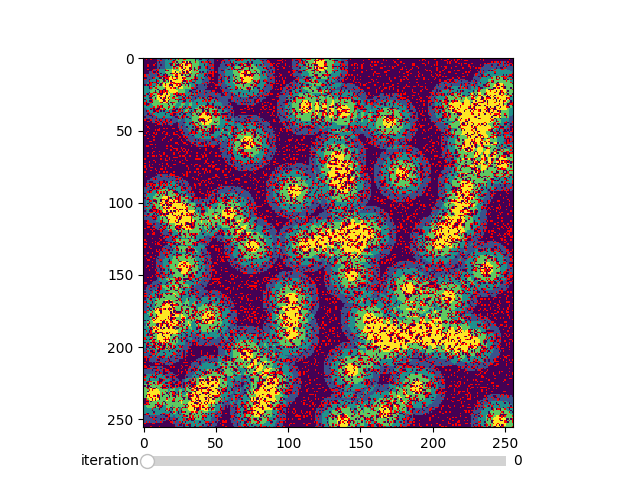

In [19]:
import sugarscape_visualiser
import importlib
importlib.reload(sugarscape_visualiser)
#%matplotlib inline 
%matplotlib widget # requires ipympl

#sugarscape_visualiser.plot_state(0)
#sugarscape_visualiser.plot_state(1)
#sugarscape_visualiser.plot_state(20)
#sugarscape_visualiser.plot_state(30)
#sugarscape_visualiser.plot_state(40)

#ani = sugarscape_visualiser.animate_states(10)

sugarscape_visualiser.display_states(100)